# EC523 Project : Stock Price Prediction

Import

In [60]:
!pip3 install pytorch-nlp
import pandas as pd
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchnlp.nn as nlpnn

##  1. Data Preprocess

First of all, let's read the data set file and take a look of it.

In [61]:
path = "/content/stock_data.csv"
stock_dataset =  pd.read_csv(path, header=0)

Let's take a look of first 5 rows of data set.

In [62]:
stock_dataset.head()

,index_code,date,open,close,low,high,volume,money,change
0,sh000001,1990/12/20,104.30,104.39,99.98,104.39,197000.0,85000.0,0.044109
1,sh000001,1990/12/21,109.07,109.13,103.73,109.13,28000.0,16100.0,0.045407
2,sh000001,1990/12/24,113.57,114.55,109.13,114.55,32000.0,31100.0,0.049666
3,sh000001,1990/12/25,120.09,120.25,114.55,120.25,15000.0,6500.0,0.049760
4,sh000001,1990/12/26,125.27,125.27,120.25,125.27,100000.0,53700.0,0.041746


In [63]:
stock_dataset.describe()

,open,close,low,high,volume,money,change
count,6109.000000,6109.000000,6109.000000,6109.000000,6.109000e+03,6.109000e+03,6109.000000
mean,1774.168370,1775.191989,1753.858407,1792.686525,2.258868e+10,6.013645e+10,0.000882
std,1047.920798,1049.208658,1033.753364,1060.291179,3.635068e+10,1.253975e+11,0.026197
min,104.300000,104.390000,99.980000,104.390000,1.500000e+04,6.500000e+03,-0.163937
25%,1100.690000,1101.490000,1087.850000,1112.100000,3.634716e+09,3.157918e+09,-0.007923
50%,1570.650000,1570.700000,1556.530000,1583.760000,8.551797e+09,9.848770e+09,0.000701
75%,2293.810000,2295.950000,2278.160000,2312.560000,1.970836e+10,7.762494e+10,0.009374
max,6057.430000,6092.060000,6040.710000,6124.040000,2.760000e+11,1.310000e+12,1.052691


What is the exact length of each column?

In [64]:
open_price = stock_dataset.open.values.astype('float32')
open_price = open_price.reshape(-1, 1)
print(open_price.shape[0])

6109


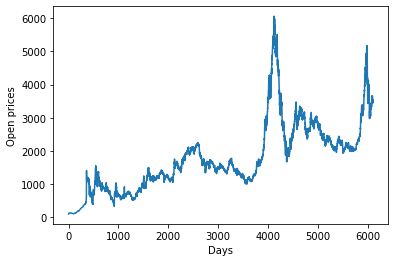

In [65]:
plt.plot(open_price)
plt.ylabel("Open prices")
plt.xlabel("Days")
plt.show()

Here is the class of parameters of this project:

In [85]:
class Config:
    
    feature_columns = list(range(2, 9))     # feature columns' indecies 
    label_columns = [2,3]                # predicted feature columns' indecies
    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  
    
    predict_day = 1             # predited length (days)
    
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # hiddent size
    lstm_layers = 2             # stacked layer number
    dropout_rate = 0.2          # dropout
    time_step = 20              # step size (day)
    epoch = 50
    
#     do_train = True
#     do_predict = True
#     shuffle_train_data = True           

    train_data_rate = 0.7      
    valid_data_rate = 0.15   
    test_data_rate = 0.15

    batch_size = 64
    learning_rate = 0.0001

    use_cuda = True
    # path
    used_frame = "pytorch"
    model_name = "model_" + ".pth"
    train_data_path = "/content/stock_data.csv"
    model_save_path = "./checkpoint/" + used_frame + "/"
    

    # save 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)    


Class of dataset process and split.

In [86]:
class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()
        self.data = np.array(self.data, dtype=np.float64)
        self.data_num = self.data.shape[0]
        ### interval of dataset
        # x_train [0:s]
        # y_train [d:s+d]
        # x_valid [s:v]
        # y_valid [s+d:v+d]
        # x_test [v:-d]
        # y_test [v+d:-1]

        self.train_num = int(self.data_num * self.config.train_data_rate)   #  self.train_num = s
        
        self.valid_num = int(self.train_num + self.data_num * self.config.valid_data_rate)  # self.valid_num = v
        
        self.mean = np.mean(self.data, axis=0)              # mean and std
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # normalization


    def read_data(self):                # read data
        init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        
        
        return init_data.values, init_data.columns.tolist()     

    
    def get_train_data(self):
        feature_data = self.norm_data[:self.train_num]  # interval [0:s]  
        
        # interval [d:s+d]  
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    

        train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        

        train_x, train_y = np.array(train_x), np.array(train_y)

        return train_x, train_y
    
    def get_valid_data(self):
        
        feature_data = self.norm_data[self.train_num : self.valid_num]  
        # interval [s:v]  
        
        # interval [s+d:v+d]  
        label_data = self.norm_data[self.config.predict_day + self.train_num : self.config.predict_day + self.valid_num,
                                    self.config.label_in_feature_index]    # create label
        
        
        valid_x = [feature_data[i:i+self.config.time_step] for i in range(self.valid_num-self.train_num-self.config.time_step)]
        valid_y = [label_data[i:i+self.config.time_step] for i in range(self.valid_num-self.train_num-self.config.time_step)]

   
        valid_x, valid_y = np.array(valid_x), np.array(valid_y)

        return valid_x, valid_y


    def get_test_data(self):
        
        feature_data = self.norm_data[self.valid_num :]  
        # feature interval[v:-d]
        
        test_x = [feature_data[i:i+self.config.time_step] for i in range(self.data_num - self.valid_num - self.config.time_step-1)]

        test_x = np.array(test_x)
        
        return test_x
    
    
    def return_label(self, dataset):
        
        if dataset =="train":
            label_data = self.data[self.config.time_step :self.train_num ,
                                            self.config.label_in_feature_index]
        elif dataset == "valid":
            label_data = self.data[self.train_num+self.config.time_step :self.valid_num ,
                                            self.config.label_in_feature_index]
        else:
            label_data = self.data[self.valid_num+self.config.time_step :-self.config.predict_day ,
                                            self.config.label_in_feature_index]
            
            
        return label_data
            
        
        

In [87]:
config = Config()
data_gainer = Data(config)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

# train_y, valid_y, test_y = train_y.reshape(), valid_y, test_y 

In [88]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(len(train_label))
print(len(valid_label))
print(len(test_label))
# print(test_y.shape)

(4256, 20, 7)
(4256, 20, 2)
(896, 20, 7)
(896, 20, 2)
(896, 20, 7)
4256
896
896


## 2. Network and Training Preview

Current net is a stacked LSTM, we are going to modify it later on 

In [ ]:
# class Net(Module):
#     def __init__(self, config):
#         super(Net, self).__init__()
#         self.lstm = nn.LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
#                             num_layers=config.lstm_layers, batch_first=True,
#                             dropout=config.dropout_rate)
#         self.linear = nn.Linear(in_features=config.hidden_size, out_features=config.output_size)


#     def forward(self, x, hidden=None):
#         lstm_out, hidden = self.lstm(x, hidden)
#         y = self.linear(lstm_out)
#         return y, hidden



In [89]:
class Net(Module):
    def __init__(self, config, attention_net=False):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                            num_layers=config.lstm_layers, batch_first=True,
                            dropout=config.dropout_rate)
        self.attention = nlpnn.Attention(config.hidden_size)
        self.attention_linear = nn.Linear(in_features=config.hidden_size, out_features=config.hidden_size)
        self.linear = nn.Linear(in_features=config.hidden_size, out_features=config.output_size)
        self.hidden_size = config.hidden_size  # 128
        self.time_step = config.time_step      # 20
        self.attention_net = attention_net     # True: attention layer
        
    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        y = 0
        if self.attention_net:
            query = self.attention_linear(torch.ones(x.shape[0], self.time_step, self.hidden_size))
            attention_out, _ = self.attention(query, lstm_out)
            y = self.linear(attention_out)
        else:
            y = self.linear(lstm_out)
        return y, hidden

In [90]:
def train(x_train, y_train, config, attention_net=False):
    print("Start training ...")
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    net = Net(config, attention_net).to(device)

    train_x, train_y = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size = config.batch_size)

    # totally s iterations
#     s = train_x.shape[0]
    optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()
    losses = []  # store losses of each iteration
    epc_mean = []  # store mean losses of each epoch
    for epoch in range(config.epoch):
        epoch_loss = []
        hidden = None
        for i, data in enumerate(train_loader):
            train_x, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            y_pred, hidden = net.forward(train_x, hidden)
#             h_t, c_t = hidden
#             h_t.detach_(), c_t.detach_()
#             hidden = (h_t, c_t)
            hidden = None
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            epoch_loss.append(loss.item())
        cur_loss = np.mean(np.array(epoch_loss))
        print("Epoch {}/{}".format(epoch+1, config.epoch), " Train Loss :{}".format(cur_loss))
        epc_mean.append(cur_loss)
        
    
    torch.save(net.state_dict(), config.model_save_path + config.model_name)
    print('Finished Training Trainset')
    print('Net parameters are saved at {}'.format(config.model_save_path + config.model_name))
    return losses, epc_mean


def loss_plot(losses):
    plt.plot(losses) 
    plt.xlabel('epoch') 
    plt.ylabel('training loss') 
    plt.title('Training Loss history') 
    plt.show()


In [91]:
_, loss_mean= train(train_x, train_y, config)

Start training ...
Epoch 1/50  Train Loss :0.9454767775040731
Epoch 2/50  Train Loss :0.6697838245265519
Epoch 3/50  Train Loss :0.44021878030790546
Epoch 4/50  Train Loss :0.31373229825785803
Epoch 5/50  Train Loss :0.2060282383419907
Epoch 6/50  Train Loss :0.17913260917637996
Epoch 7/50  Train Loss :0.16016939446441272
Epoch 8/50  Train Loss :0.14278853503611885
Epoch 9/50  Train Loss :0.1268813351773893
Epoch 10/50  Train Loss :0.1123502065580505
Epoch 11/50  Train Loss :0.09966188283122854
Epoch 12/50  Train Loss :0.08878500494800175
Epoch 13/50  Train Loss :0.08011516874808985
Epoch 14/50  Train Loss :0.07362921712850568
Epoch 15/50  Train Loss :0.0689463790283719
Epoch 16/50  Train Loss :0.06449266473776591
Epoch 17/50  Train Loss :0.06566529138945043
Epoch 18/50  Train Loss :0.07409564544683073
Epoch 19/50  Train Loss :0.11459311811642638
Epoch 20/50  Train Loss :0.07282779081863587
Epoch 21/50  Train Loss :0.07276176572638328
Epoch 22/50  Train Loss :0.053798761468992304
Epoch

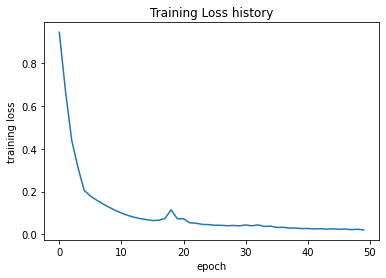

In [92]:
loss_plot(loss_mean)

In [93]:
def predict(x_test, config, attention_net=False):
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    y_pred = torch.empty((0, len(config.label_columns))).to(device)
    y_hat = []
    test_X = torch.from_numpy(x_test).float()
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    
    net = Net(config, attention_net).to(device)
    net.load_state_dict(torch.load(config.model_save_path + config.model_name))
    net.eval()
    hidden = None
    for data in test_loader:
        tmp = []
        x = data[0].to(device)
        y, hidden = net.forward(x, hidden)
        hidden = None
#         y_pred_0 = torch.cat((y_pred, y[0]), 0)
        tmp.append(y[0][-1][0].item())
        tmp.append(y[0][-1][1].item())
        y_hat.append(tmp)
    return np.array(y_hat)


def up_down_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result


def evaluate(y_pred, y_test, data_gainer):
    labels_open = []
    labels_close = []
    for i in range(y_test.shape[0]):
        labels_open.append(y_test[i][0])
    for i in range(y_test.shape[0]):
        labels_close.append(y_test[i][1])
    
    
    
    print("###############################################################")
    print("Evaluation of open price predction on valid set:")
    
    y_pred_0 = y_pred[:,0] * data_gainer.std[0] + data_gainer.mean[0]
    
    
    # Error comptuer of open price prediction
    #Root Mean Square Error
    RMSE = np.sqrt(np.sum((np.array(labels_open) - y_pred_0) ** 2) / len(labels_open)) 
    # Mean Absolute Percentage Error
    MAPE = np.sum((np.array(labels_open) - y_pred_0)/np.array(labels_open))/len(labels_open)*100 
    # Mean Bias Error
    MBE = np.sum((np.array(labels_open) - y_pred_0)) / len(labels_open)
    print("RMSE on validation set is {}".format(RMSE))
    print("MAPE on validation set is {}".format(MAPE))
    print("MBE on validation set is {}".format(MBE))    
    up_down_accu = up_down_accuracy(labels_open, y_pred_0)
    print("Up and down accuracy on validation set is {}%".format(round(up_down_accu*100),2))


    plt.xlabel('Days') 
    plt.ylabel('Price') 
    plt.title('Valid Evaluation of Open prices for 100 days') 
    plt.plot(y_pred_0.tolist()[:100], 'r', label = "predict")
    plt.plot(labels_open[:100], 'b', label = "real")
    plt.legend(loc="upper right")
    plt.show()
    
    
    # Error comptuer of close price prediction

    print("###############################################################")
    print("Evaluation of close price predction on valid set:")
    y_pred_1 = y_pred[:,1] * data_gainer.std[1] + data_gainer.mean[1]
    
    
    # Error comptuer of open price prediction
    #Root Mean Square Error
    RMSE = np.sqrt(np.sum((np.array(labels_close) - y_pred_1) ** 2) / len(labels_close)) 
    # Mean Absolute Percentage Error
    MAPE = np.sum((np.array(labels_close) - y_pred_1)/np.array(labels_close))/len(labels_close)*100 
    # Mean Bias Error
    MBE = np.sum((np.array(labels_close) - y_pred_1)) / len(labels_close)
    print("RMSE on validation set is {}".format(RMSE))
    print("MAPE on validation set is {}".format(MAPE))
    print("MBE on validation set is {}".format(MBE))    
    up_down_accu = up_down_accuracy(labels_close, y_pred_1)
    print("Up and down accuracy on validation set is {}%".format(round(up_down_accu*100),2))


    plt.xlabel('Days') 
    plt.ylabel('Price') 
    plt.title('Valid Evaluation of Close prices for 100 days') 
    plt.plot(y_pred_1.tolist()[:100], 'r', label = "predict close")
    
    
    plt.plot(labels_close[:100], 'b', label = "real close")
    plt.legend(loc="upper right")
    plt.show()


In [94]:
y_pred = predict(valid_x, config)

In [77]:
print(y_pred.shape)

(896, 2)


###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 79.22104861574323
MAPE on validation set is -1.6578605860304871
MBE on validation set is -47.13716050880091
Up and down accuracy on validation set is 72.0%


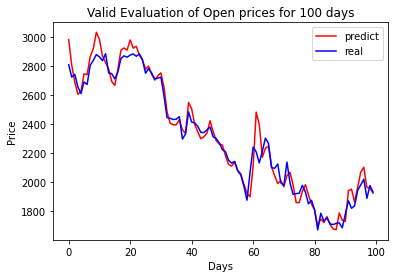

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 88.13661941875229
MAPE on validation set is -1.7220644658790287
MBE on validation set is -49.05310186451102
Up and down accuracy on validation set is 50.0%


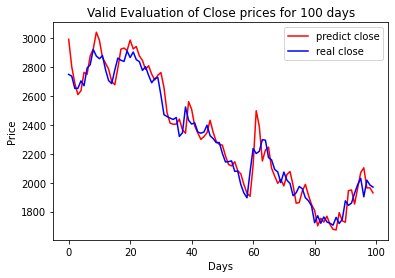

In [95]:
evaluate(y_pred, valid_label, data_gainer)

##Attention layer

In [80]:
_, loss_mean_attention = train(train_x, train_y, config, True)

Start training ...
Epoch 1/20  Train Loss :0.9461114805629616
Epoch 2/20  Train Loss :0.8740797305771553
Epoch 3/20  Train Loss :0.44326245135092524
Epoch 4/20  Train Loss :0.140901808656488
Epoch 5/20  Train Loss :0.07914090549760956
Epoch 6/20  Train Loss :0.06228148396502235
Epoch 7/20  Train Loss :0.05116428979220731
Epoch 8/20  Train Loss :0.03832164768185189
Epoch 9/20  Train Loss :0.028857654471422977
Epoch 10/20  Train Loss :0.022163675093689737
Epoch 11/20  Train Loss :0.02906082484370737
Epoch 12/20  Train Loss :0.0465241589004855
Epoch 13/20  Train Loss :0.11850058455141817
Epoch 14/20  Train Loss :0.07074987315294791
Epoch 15/20  Train Loss :0.058482454730885855
Epoch 16/20  Train Loss :0.030322106032972848
Epoch 17/20  Train Loss :0.02648806232792228
Epoch 18/20  Train Loss :0.01863572565115877
Epoch 19/20  Train Loss :0.01933023288720913
Epoch 20/20  Train Loss :0.01620467629851843
Finished Training Trainset
Net parameters are saved at ./checkpoint/pytorch/model_.pth


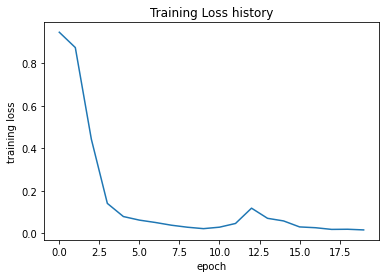

In [81]:
loss_plot(loss_mean_attention)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 196.2776770417924
MAPE on validation set is -3.0343690834636896
MBE on validation set is -80.83462956546246
Up and down accuracy on validation set is 51.0%


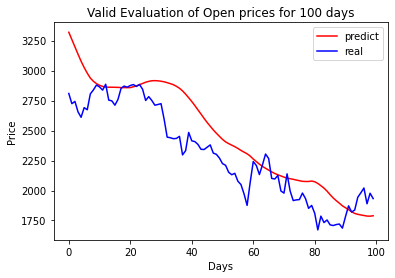

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 201.61796793133888
MAPE on validation set is -3.075270077796232
MBE on validation set is -81.61782411447953
Up and down accuracy on validation set is 53.0%


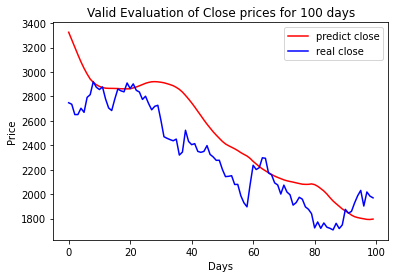

In [82]:
y_pred_attention = predict(valid_x, config, True)
evaluate(y_pred_attention, valid_label, data_gainer)

## 3. Parameter Tuning

Parameter tuning to increase performaces on the valid set